# Multidimensional Visualization of Calibration Comparisions

## Abstract
   Today there exists many different approaches for creating corrections for the modern Vector Network Analyzer. Each of these methods have relative advantages based on their estimated uncertainties, measurement artifact requirements, frequency converage, and complexity. The breadth of correction methods are becoming more accesible to researchers as tools provided by VNA vendors and national metrology laboratories have become more numerous and more accomidating to the varied methods. These tools are also offering better uncertainty analysis regarding the correction techniques of choice. In order to compare these different methods, researchers have historically turned to worst cast estimates or bench mark two tier calibrations comparing the calibration of interest to the T-R-L method. Here we present a way to visualize two calibrations with estimated uncertainties over a complex plane.


## Methods and Purposed Figures

1. A plot comparing worst case metric in Rs and TRL (standard radical)
2. A figure showing typcal standards on the complex plane, the equivelent of the worst case in the plane and a full calibration on the plane.
3. a multidimension comparision of TRL, RS, OSLT and OSL unknown thru

## Corollary
1. The comparision of two sparameters with uncertainty using Standard Error

In [1]:
from pyMeasure import *

Importing Code.Utils.Names
Importing Code.DataHandlers.NISTModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.TouchstoneModels
The module smithplot was not found,please put it on the python path
Importing Code.DataHandlers.XMLModels
Importing Code.DataHandlers.RadiCALModels
Importing Code.DataHandlers.ZipModels
Importing Code.DataHandlers.Translations
The module pdfkit was not found or had an error,please check module or put it on the python path use pip install pdfkit and also install wkhtmltopdf
Importing Code.DataHandlers.StatistiCALModels
Importing Code.DataHandlers.MUFModels
Importing Code.Analysis.SParameter
The module pdfkit was not found or had an error,please check module or put it on the python path use pip install pdfkit and also install wkhtmltopdf
Importing Code.InstrumentControl.Instruments
Importing Code.InstrumentControl.Experiments


In [213]:
class StandardErrorModel(AsciiDataTable):
    """Model that stores data for standard error in the form [[independent_variable,SEValue1,..,SEValueN]..]
    See function `pyMeasure.Code.Analysis.Uncertainty.standard_error_data_table`"""
    def __init__(self,file_path,**options):
        """Intializes the StandardErrorModel Class"""
        AsciiDataTable.__init__(self,file_path,**options)
    #todo: add is column good(column_name)
    def column_conforms(self,column_name):
        "For a given column_name returns true if all values have an absolute value less than one"
        column_data=self.get_column(column_name)
        filtered_list=filter(lambda x: abs(x)>1,column_data)
        if filtered_list:
            return False
        else:
            return True
    def get_conformation_dictionary(self):
        """Returns a dictionary of the form {column_name:column_comforms(column_name)}"""
        conformation_dictionary={column_name:self.column_conforms(column_name) for column_name in self.column_names[:]}
        conformation_dictionary[self.column_names[0]]=True
        return conformation_dictionary
        
    def show(self,**options):
        """Shows a plot of the StandardErrorModel"""
        defaults={"display_legend":False,
                  "save_plot":False,
                  "directory":None,
                  "specific_descriptor":self.options["specific_descriptor"],
                  "general_descriptor":self.options["general_descriptor"]+"Plot",
                  "file_name":None,
                  "plots_per_column":2,
                  "plot_format":'r--x',
                 "fill_unit_rectangle":True,
                 "fill_color":'b',
                 "fill_opacity":.25,
                 "fill_edge_color":'r'}
        
        plot_options={}
        for key,value in defaults.iteritems():
            plot_options[key]=value
        for key,value in options.iteritems():
            plot_options[key]=value
        
        x_data=self.get_column(column_index=0)
        y_columns=self.column_names[1:]
        number_plots=int(len(self.column_names)-1)
        number_columns=int(plot_options["plots_per_column"])
        number_rows=int(round(float(number_plots)/float(number_columns)))
        
        fig, axes = plt.subplots(nrows=number_rows,ncols=number_columns, figsize=(8,6),dpi=80)
        for plot_index,ax in enumerate(axes.flat):
            y_data=self.get_column(column_name=y_columns[plot_index])
            ax.plot(x_data,y_data,plot_options["plot_format"],label=y_columns[plot_index])
            ax.set_xlabel(self.column_names[0])
            ax.set_ylabel("Standard Error")
            ax.set_title(y_columns[plot_index])
            if plot_options["display_legend"]:
                ax.legend()
            if plot_options["fill_unit_rectangle"]:
                x_min=min(x_data)
                x_max=max(x_data)
                rect__x=np.array([x_min,x_max])
                
                ax.fill_between(rect__x,np.array([1.0,1.0]),np.array([-1.0,-1.0]), 
                                color=plot_options["fill_color"],
                                alpha=plot_options["fill_opacity"], 
                                edgecolor=plot_options["fill_edge_color"])
        plt.tight_layout()
        # Dealing with the save option
        if plot_options["file_name"] is None:
            file_name=auto_name(specific_descriptor=plot_options["specific_descriptor"],
                                general_descriptor=plot_options["general_descriptor"],
                                directory=plot_options["directory"],extension='png',padding=3)
        else:
            file_name=plot_options["file_name"]
        if plot_options["save_plot"]:
            #print file_name
            plt.savefig(os.path.join(plot_options["directory"],file_name))
        else:
            plt.show()
        return fig
    
class StandardErrorError(Exception):
    "Error class for standard error functions and classes"
    pass
# Comparison of two curves where at least one has error
# possible error types: table, constant, fractional, functional and None
def standard_error_data_table(table_1,table_2,**options):
    """standard error data table takes two tables and creates a table that is the standard error of the two tables, 
    at least one table must have uncertainties associated with it. The input tables are assumed to have data
    in the form [[x, y1, y2,...]..] Uncertatinties can be specified as a column name in the respective 
    table, fractional, constant, or a function of the values. The returned table is an object
    of the class StandardErrorModel(AsciiDataTable) that has data in the form 
    [[independent_varaible,SEValue1,SEValue2...]...] where column names are formed by 
    appending SE to the value column names. To plot the table use result.show()
    """

    defaults={}
    error_options={"independent_variable_column_name":"Frequency",
                  "value_column_names":['magS11','argS11','magS21',
                                                'argS21','magS22','argS22'],
                  "table_1_uncertainty_column_names":['uMgS11','uAgS11',
                                                      'uMgS21','uAgS21','uMgS22','uAgS22'],
                  "table_2_uncertainty_column_names":['uMgS11','uAgS11',
                                                      'uMgS21','uAgS21','uMgS22','uAgS22'],
                   "uncertainty_table_1":None,
                   "uncertainty_table_2":None,
                   "uncertainty_function_table_1":None,
                   "uncertainty_function_table_2":None,
                   "uncertainty_function":None,
                   "uncertainty_type":None,
                   "table_1_uncertainty_type":"table",
                   "table_2_uncertainty_type":None,
                   "expansion_factor":1,
                   'debug':True}
    
    for key,value in defaults.iteritems():
        error_options[key]=value
    for key,value in options.iteritems():
        error_options[key]=value
    # first check type, if it is a panadas data frame a little conversion is needed, else is for all other models
    if type(table_1) in [pandas.DataFrame]:
        table_1=DataFrame_to_AsciiDataTable(table_1)
    if type(table_2) in [pandas.DataFrame]:
        table_2=DataFrame_to_AsciiDataTable(table_2)
    # Begin by checking at least one table has an error associated with it
    if error_options["table_1_uncertainty_type"] is None and error_options["table_2_uncertainty_type"] is None:
        raise StandardErrorError("Undefined Error For Both Tables: Define at least one of "
                                 "table_1_uncertainty_type or table_2_uncertainty_type to be a value other than None")
    if error_options["expansion_factor"]:
        expansion_factor=float(error_options["expansion_factor"])
    else:
        expansion_factor=1
    # first find a unique list of the independent variable for both curves
    if error_options["debug"]:
        begin_time=datetime.datetime.utcnow()
        print("started finding intersection of " 
              "table_1[{0}] and table_2[{1}] at {2}".format(error_options["independent_variable_column_name"],
                                                           error_options["independent_variable_column_name"],
                                                           begin_time))
    x_set_table_1=set(table_1[error_options["independent_variable_column_name"]])
    x_set_table_2=set(table_2[error_options["independent_variable_column_name"]])
    unique_x=sorted(list(x_set_table_1.intersection(x_set_table_2)))
    if error_options["debug"]:
        end_time=datetime.datetime.utcnow()
        print("finished finding intersection at {0}".format(end_time))
        delta_time=end_time-begin_time
        print("it took {0} to find the intersection that contained {1} points".format(delta_time,len(unique_x)))
    if not unique_x:
        raise StandardErrorError("No points in the intersection, please either interpolate one data set or compare "
                                 "with another data set")
    
    # next build the new data set 
    out_data=[]
    x_column_index_table_1=table_1.column_names.index(error_options["independent_variable_column_name"])
    x_column_index_table_2=table_2.column_names.index(error_options["independent_variable_column_name"])
    # we choose the row by using unique_x
    for x_value in unique_x:
        # here if there are multiple values for x_value we ignore them
        table_1_row=filter(lambda x: x[x_column_index_table_1]==x_value,table_1.data)[0]
        # we begin a new_row
        table_2_rows=filter(lambda x: x[x_column_index_table_1]==x_value,table_2.data)
        for table_2_row in table_2_rows:
            new_row=[x_value]
            for column_index,column_name in enumerate(error_options["value_column_names"]):
                value_1_column_selector=table_1.column_names.index(column_name)
                value_2_column_selector=table_2.column_names.index(column_name)
                value_1=table_1_row[value_1_column_selector]
                value_2=table_2_row[value_2_column_selector]
                # now we assign the error to value 1
                if error_options["table_1_uncertainty_type"] is None:
                    error_1=0
                elif re.search("table|list",error_options["table_1_uncertainty_type"],re.IGNORECASE):
                    error_1_column_selector=table_1.column_names.index(error_options["table_1_uncertainty_column_names"][column_index])
                    error_1=table_1_row[error_1_column_selector]
                elif re.search("con|fixed",error_options["table_1_uncertainty_type"],re.IGNORECASE):
                    error_1=float(error_options["uncertainty_table_1"])
                elif re.search("fract",error_options["table_1_uncertainty_type"],re.IGNORECASE):
                    error_1=float(error_options["uncertainty_table_1"])*value_1
                elif re.search("func",error_options["table_1_uncertainty_type"],re.IGNORECASE):
                    error_1=error_options["uncertainty_table_1_function"](value_1)
                else:
                    error_1=0
                # now the same for table 2
                if error_options["table_2_uncertainty_type"] is None:
                    error_2=0
                elif re.search("table|list",error_options["table_2_uncertainty_type"],re.IGNORECASE):
                    error_2_column_selector=table_2.column_names.index(error_options["table_2_uncertainty_column_names"][column_index])
                    error_2=table_2_row[error_2_column_selector]
                elif re.search("con|fixed",error_options["table_2_uncertainty_type"],re.IGNORECASE):
                    error_2=float(error_options["uncertainty_table_2"])
                elif re.search("fract",error_options["table_2_uncertainty_type"],re.IGNORECASE):
                    error_2=float(error_options["uncertainty_table_2"])*value_2
                elif re.search("func",error_options["table_2_uncertainty_type"],re.IGNORECASE):
                    error_2=error_options["uncertainty_table_2_function"](value_2)
                else:
                    error_2=0
                # now calculate the value and append
                
                standard_error=(value_1-value_2)/(expansion_factor*math.sqrt(error_1**2+error_2**2))
                new_row.append(standard_error)
            out_data.append(new_row)
        # now we handle the standard error table creation
    standard_error_column_names=[error_options["independent_variable_column_name"]]
    for column_name in error_options["value_column_names"]:
        standard_error_column_names.append("SE"+column_name)
    error_options["column_names"]=standard_error_column_names[:]
    error_options["column_types"]=['float' for column in  standard_error_column_names[:]]
    error_options["data"]=out_data[:]
    out_table=StandardErrorModel(None,**error_options)
    return out_table
            
    

In [163]:
import random
import numpy
table_1=TwoPortCalrepModel(os.path.join(TESTS_DIRECTORY,'N205RV.asc'))
table_2=TwoPortCalrepModel(os.path.join(TESTS_DIRECTORY,'N205RV.asc'))
for row in table_2.joined_table.data:
    mag_noise=random.gauss(0,.05)
    phase_noise=random.gauss(0,30)
    
    row[1]=row[1]+mag_noise
    row[6]=row[6]+phase_noise
    row[11]=row[11]+mag_noise
    row[16]=row[16]+phase_noise
table_3=SNP(os.path.join(TESTS_DIRECTORY,'704b.S2P'))
table_3.change_data_format('MA')
table_4=TwoPortCalrepModel(os.path.join(TESTS_DIRECTORY,'922729.asc'))

<IPython.core.display.Javascript object>


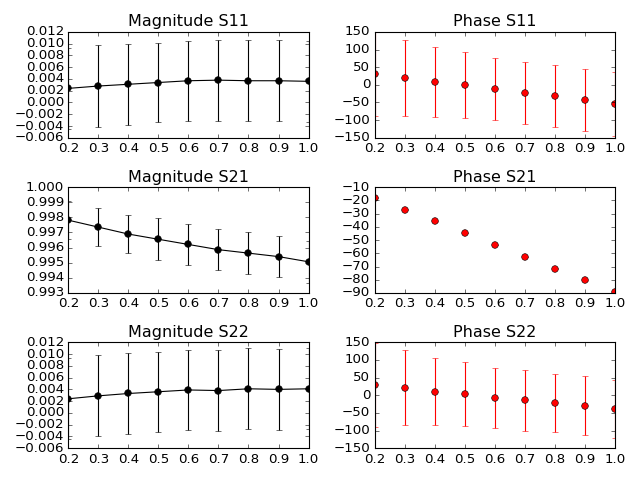

In [154]:
fig=table_1.show()

In [ ]:
str(datetime.datetime.utcnow())

In [219]:
SE=standard_error_data_table(table_1.joined_table,table_2.joined_table,expansion_factor=5,
                             table_2_uncertainty_type="table",uncertainty_table_2=.2)

started finding intersection of table_1[Frequency] and table_2[Frequency] at 2017-01-28 05:14:21.059000
finished finding intersection at 2017-01-28 05:14:21.059000
it took 0:00:00 to find the intersection that contained 9 points


In [156]:
print SE

Frequency,SEmagS11,SEargS11,SEmagS21,SEargS21,SEmagS22,SEargS22
0.2,-0.0688905086572,-0.107181184327,-0.376166489324,-60.4603956924,0.0,0.0
0.3,-0.815751101983,-0.0184839920377,-4.45634065068,-9.44531993126,0.0,0.0
0.4,-3.5455715983,0.0422963501697,-19.3779116891,19.1006472244,0.0,0.0
0.5,-0.70784434945,0.0205187746666,-3.4960669689,8.70369114494,0.0,0.0
0.6,2.6684549382,-0.17882862145,13.1841412412,-72.2630202131,0.0,0.0
0.7,2.95600662448,0.101943199379,14.8247560198,40.4760839354,0.0,0.0
0.8,-0.54696235444,0.127561121615,-2.74371873011,50.8620981275,0.0,0.0
0.9,2.13984637289,-0.0204416757714,10.7365498923,-7.9153723661,0.0,0.0
1.0,-2.57311692229,-0.0842530632999,-12.9149185815,-33.1407592902,0.0,0.0


<IPython.core.display.Javascript object>


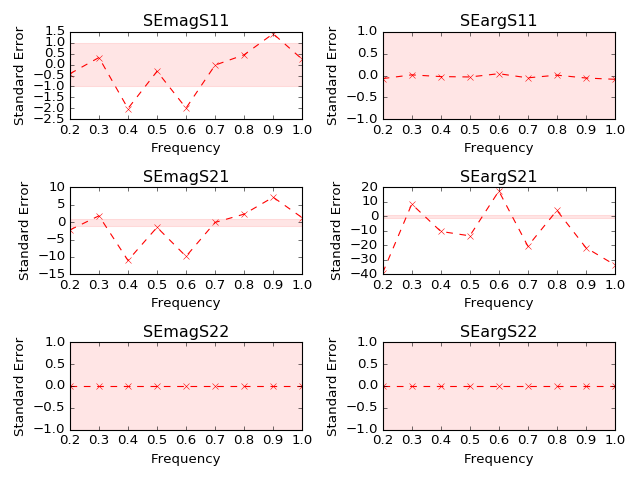

In [220]:
%matplotlib notebook
fig=SE.show(fill_color='r',fill_opacity=.1)

In [218]:
SE.column_conforms('SEmagS22')

True

In [217]:
SE.get_conformation_dictionary()

{'Frequency': True,
 'SEargS11': True,
 'SEargS21': False,
 'SEargS22': True,
 'SEmagS11': False,
 'SEmagS21': False,
 'SEmagS22': True}

In [161]:
SE2=standard_error_data_table(table_1.joined_table,table_3,expansion_factor=2,
                             table_2_uncertainty_type=None,uncertainty_table_2=.2)

started finding intersection oftable_1[Frequency] and table_2[Frequency] at 2017-01-28 03:28:17.317000
finished finding intersection at 2017-01-28 03:28:17.317000
it took 0:00:00 to find the intersection that contained 0 points


StandardErrorError: No points in the intersection, please either interpolate one data set or comparewith another data set

In [165]:
SE2=standard_error_data_table(table_1.joined_table,table_4.joined_table,expansion_factor=2,
                             table_2_uncertainty_type='table',uncertainty_table_2=.2)

started finding intersection oftable_1[Frequency] and table_2[Frequency] at 2017-01-28 04:09:00.190000
finished finding intersection at 2017-01-28 04:09:00.190000
it took 0:00:00 to find the intersection that contained 2 points


<IPython.core.display.Javascript object>


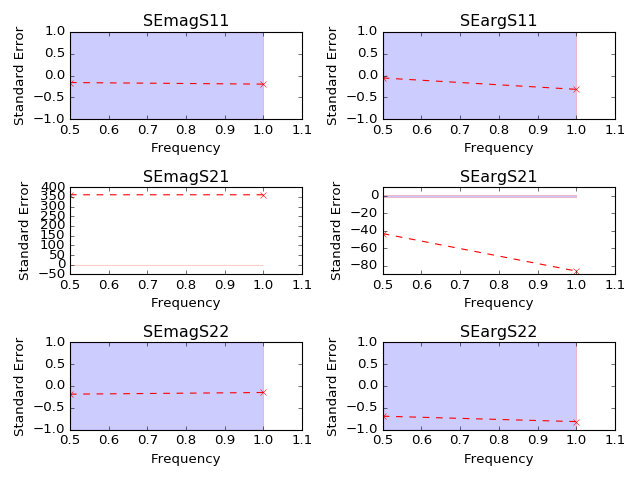

In [167]:
fig=SE2.show()

In [169]:
#fig

In [162]:
from pyMeasure.Code.Analysis.Interpolation import *

In [175]:
def interpolate_table(table,independent_variable_list):
    """Returns a copy of the table interpolated to the independent variable list"""
    functions=interpolate_data(table.data)
    new_data=build_interpolated_data_set(independent_variable_list,functions)
    new_table=table.copy()
    new_table.data=new_data
    return new_table

In [200]:
interp_1=interpolate_table(table_2.joined_table,np.linspace(0.2,1,10000).tolist())
interp_2=interpolate_table(table_4.joined_table,np.linspace(0.2,1,10000).tolist())

In [184]:
interp["Frequency"][0:2]

[0.2, 0.2080808080808081]

In [185]:
table_2.joined_table["Frequency"][0:2]

[0.2, 0.3]

In [203]:
SE5=standard_error_data_table(interp_1,interp_2,
                              table_2_uncertainty_type='table',
                              expansion_factor=600)

started finding intersection oftable_1[Frequency] and table_2[Frequency] at 2017-01-28 05:03:29.984000
finished finding intersection at 2017-01-28 05:03:29.994000
it took 0:00:00.010000 to find the intersection that contained 10000 points


<IPython.core.display.Javascript object>


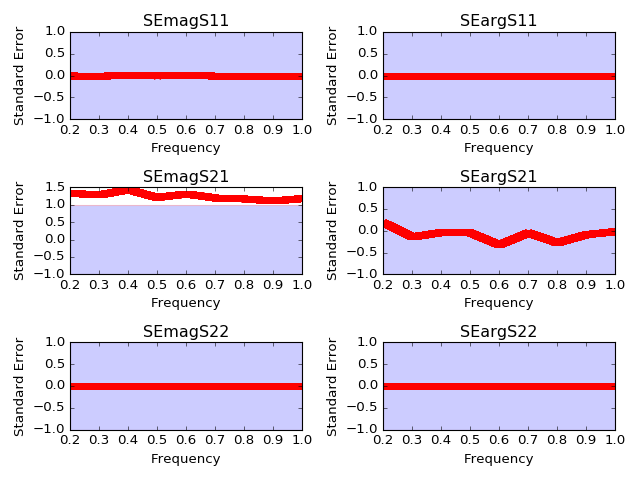

In [212]:
fig=SE5.show()

In [205]:
SE5.get_conformation_dictionary()

{'Frequency': True,
 'SEargS11': True,
 'SEargS21': True,
 'SEargS22': True,
 'SEmagS11': True,
 'SEmagS21': False,
 'SEmagS22': True}